In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import ants
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
import ipywidgets as widgets
import pydicom
import os
import glob
%matplotlib notebook



In [3]:
def apply_window(data, ww, wc, top_is_white=True):
    windowed_data = np.copy(data).astype(np.float64)
    floor = wc - ww / 2.
    ceil = wc + ww / 2.
    windowed_data -= floor
    windowed_data /= (ceil - floor)
    windowed_data[windowed_data < 0] = 0
    windowed_data[windowed_data > 1] = int(top_is_white)
    windowed_data *= float(255)
    return windowed_data.astype(np.uint16)

def interactive_3d(array, mask=None):
    %matplotlib notebook
    fig,ax = plt.subplots(1,1,figsize=(8,8))

    def show_slice(slice_number, ww, wc):
        slice_ = array[slice_number]
        if ww != -1 and wc != -1:
            slice_ = apply_window(slice_, ww, wc)
        ax.imshow(slice_, cmap='bone')
        if mask is not None: 
            masked = np.ma.masked_where(mask[slice_number] == 0, mask[slice_number])
            ax.imshow(masked, 'jet', interpolation='none', alpha=0.5)
        fig.canvas.draw_idle()
    
    interact(show_slice, 
             slice_number=widgets.IntSlider(min=0, max=len(array)-1, step=1, value=10),
             ww=widgets.IntSlider(min=-1, max=1000, step=1, value=600),
             wc=widgets.IntSlider(min=-1, max=1000, step=1, value=300),
            )

In [4]:
def interactive_3d_two_scans(array, array_2):
    fig, (ax1, ax2) = plt.subplots(1,2)

    def show_slice(slice_number, ww, wc):
        slice_ = array[np.min([slice_number, array.shape[0]-1])]
        slice_2 = array_2[np.min([slice_number, array_2.shape[0]-1])]
        if ww != -1 and wc != -1:
            slice_ = apply_window(slice_, ww, wc)
            slice_2 = apply_window(slice_2, ww, wc)
        ax1.imshow(slice_, cmap='bone')
        ax2.imshow(slice_2, cmap='bone')
        fig.canvas.draw_idle()
    
    interact(show_slice, 
             slice_number=widgets.IntSlider(min=0, max=np.max([len(array)-1, len(array_2)-1]), step=1, value=10),
             ww=widgets.IntSlider(min=-1, max=1000, step=1, value=-1),
             wc=widgets.IntSlider(min=-1, max=1000, step=1, value=-1),
            )

# Get dataset

## CQ500 dataset

http://headctstudy.qure.ai/dataset

In [5]:
moving_series_path = '/path/to/your/file/CT000238.nii.gz'

In [6]:
moving_series = nib.load(moving_series_path).get_data()

/Users/clara/.virtualenvs/vizdev3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



In [7]:
moving_series = np.transpose(moving_series, [2, 1, 0])
moving_series.shape

(239, 512, 512)

<IPython.core.display.Javascript object>


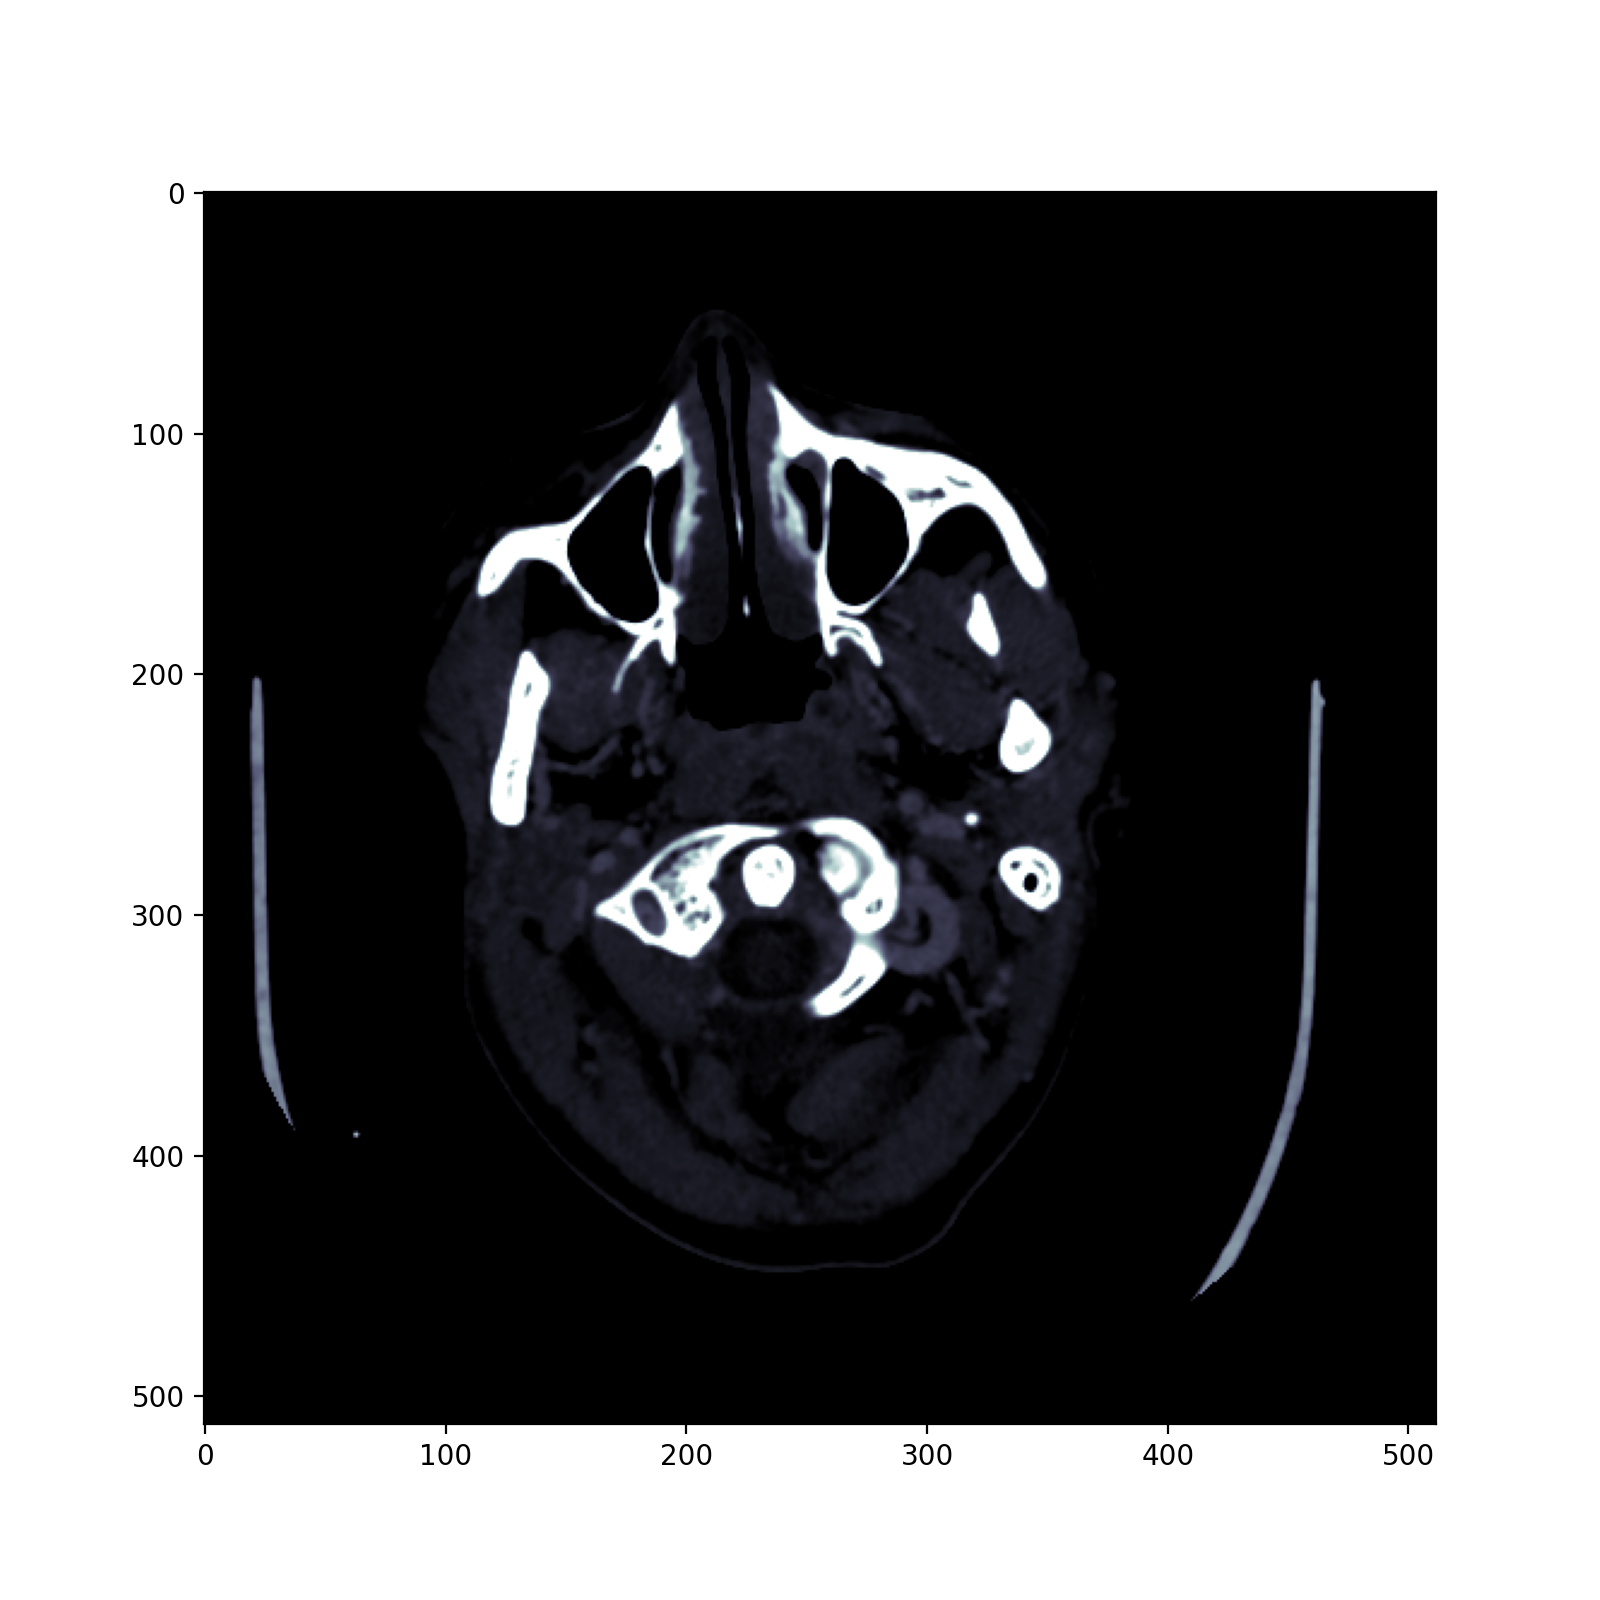

interactive(children=(IntSlider(value=10, description='slice_number', max=238), IntSlider(value=600, descripti…

In [8]:
interactive_3d(moving_series)

## MNI305

http://nist.mni.mcgill.ca/mni-average-brain-305-mri/

In [8]:
static_series_path = '/path/to/your/file/average305_t1_tal_lin.nii'

In [9]:
static_series = nib.load(static_series_path).get_data()

/Users/clara/.virtualenvs/vizdev3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



In [10]:
static_series = np.transpose(static_series, [2, 1, 0])
static_series.shape

(156, 220, 172)

We're gonna want to flip the MRI upside down so that both scans have the same orientation

In [11]:
static_series = np.flip(static_series, 1)

<IPython.core.display.Javascript object>


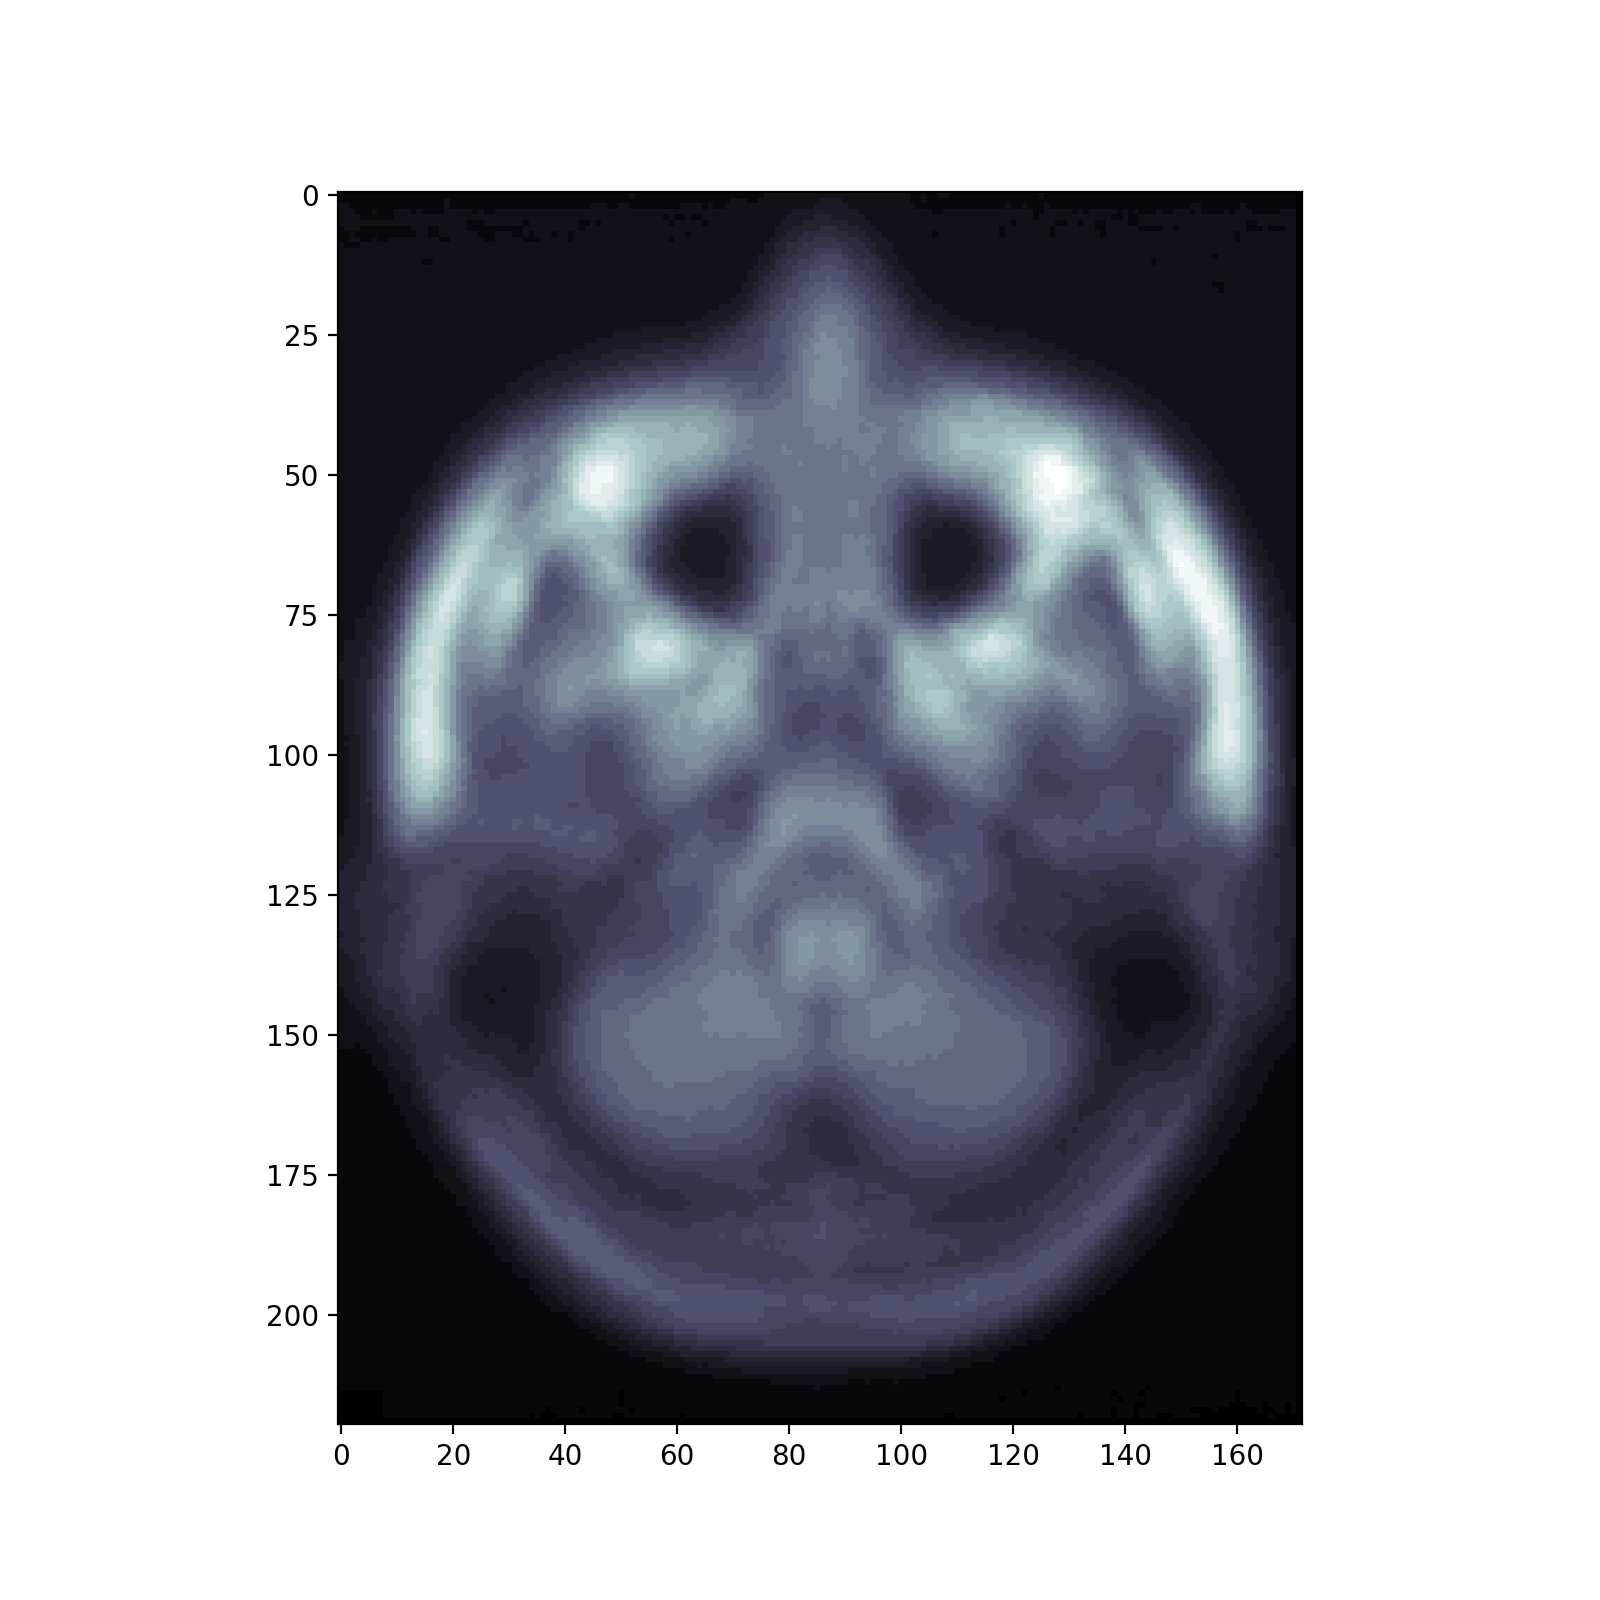

interactive(children=(IntSlider(value=10, description='slice_number', max=155), IntSlider(value=600, descripti…

In [13]:
interactive_3d(static_series)

# Registration

In [12]:
AFFINE_TRANSFORM = 'Affine'
SYN_TRANSFORM = 'SyN'
TRSAA_TRANSFORM = 'TRSAA'
MI_METRIC = 'mattes'
CC_METRIC = 'gc'
INTERPOLATION_TYPE = 'bSpline'
DEFAULT_REGISTRATION_ITERATIONS = (100, 100, 100)

def get_ants_from_numpy(arr):
    arr = np.copy(np.transpose(arr, [1, 2, 0]))
    arr = arr.astype(np.float32)
    return ants.from_numpy(arr)


def get_numpy_from_ants(a):
    arr = a.numpy()
    arr = np.transpose(arr, [2, 0, 1])
    arr = arr.astype(np.int)
    return arr


def get_transformation_params(reference_ants: ants.ANTsImage, moving_atns: ants.ANTsImage, registration_iterations: tuple = DEFAULT_REGISTRATION_ITERATIONS,
                              transform_type: str = SYN_TRANSFORM, mask: ants.ANTsImage = None, aff_metric=MI_METRIC) -> dict:
    return ants.registration(fixed=reference_ants, moving=moving_atns, type_of_transform=transform_type, reg_iterations=registration_iterations, aff_metric=aff_metric, mask=mask)


def apply_transformation(reference_ants: ants.ANTsImage, moving_ants: ants.ANTsImage, transformation: dict, interpolator: str = INTERPOLATION_TYPE) -> ants.ANTsImage:
    return ants.apply_transforms(fixed=reference_ants, moving=moving_ants,
                                 transformlist=transformation['fwdtransforms'], interpolator=interpolator)


In [13]:
def register_series(moving_series_array: np.ndarray, reference_series_array: np.ndarray,
                    registration_iterations=DEFAULT_REGISTRATION_ITERATIONS, 
                    transform_type: str = SYN_TRANSFORM, 
                    aff_metric=MI_METRIC) -> (np.ndarray, dict):
    # convert both scans to ants objects
    moving_series_ants = get_ants_from_numpy(moving_series_array)
    reference_series_ants = get_ants_from_numpy(reference_series_array)

    # get transformation parameters
    transformation = get_transformation_params(reference_series_ants, moving_series_ants, 
                                               registration_iterations=registration_iterations, 
                                               transform_type=transform_type, 
                                               aff_metric=aff_metric)

    # apply the transformation
    registered_ants_series = apply_transformation(reference_series_ants, moving_series_ants, 
                                                  transformation, 
                                                  interpolator=INTERPOLATION_TYPE)

    # retrieve registered numpy array
    registered_series_array = get_numpy_from_ants(registered_ants_series)
    return registered_series_array, transformation

## Deformable Registration

In [58]:
registered_series_array, transformation = register_series(moving_series, static_series, 
                                                          registration_iterations=(10, 10, 10))

Let's look what we got

In [17]:
print(f'Shape comparison')
print(f'Moving image shape before registration: {moving_series.shape}')
print(f'Target image shape before registration: {static_series.shape}')
print(f'Moving image shape after registration: {registered_series_array.shape}')

Shape comparison
Moving image shape before registration: (239, 512, 512)
Target image shape before registration: (156, 220, 172)
Moving image shape after registration: (156, 220, 172)


In [147]:
transformation

{'warpedmovout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (220, 172, 156)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512, 239)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'fwdtransforms': ['/var/folders/jw/myx7w5611j1150smt68z8dyr0000gn/T/tmpjxqp7ier1Warp.nii.gz',
  '/var/folders/jw/myx7w5611j1150smt68z8dyr0000gn/T/tmpjxqp7ier0GenericAffine.mat'],
 'invtransforms': ['/var/folders/jw/myx7w5611j1150smt68z8dyr0000gn/T/tmpjxqp7ier0GenericAffine.mat',
  '/var/folders/jw/myx7w5611j1150smt68z8dyr0000gn/T/tmpjxqp7ier1InverseWarp.nii.gz']}

<IPython.core.display.Javascript object>


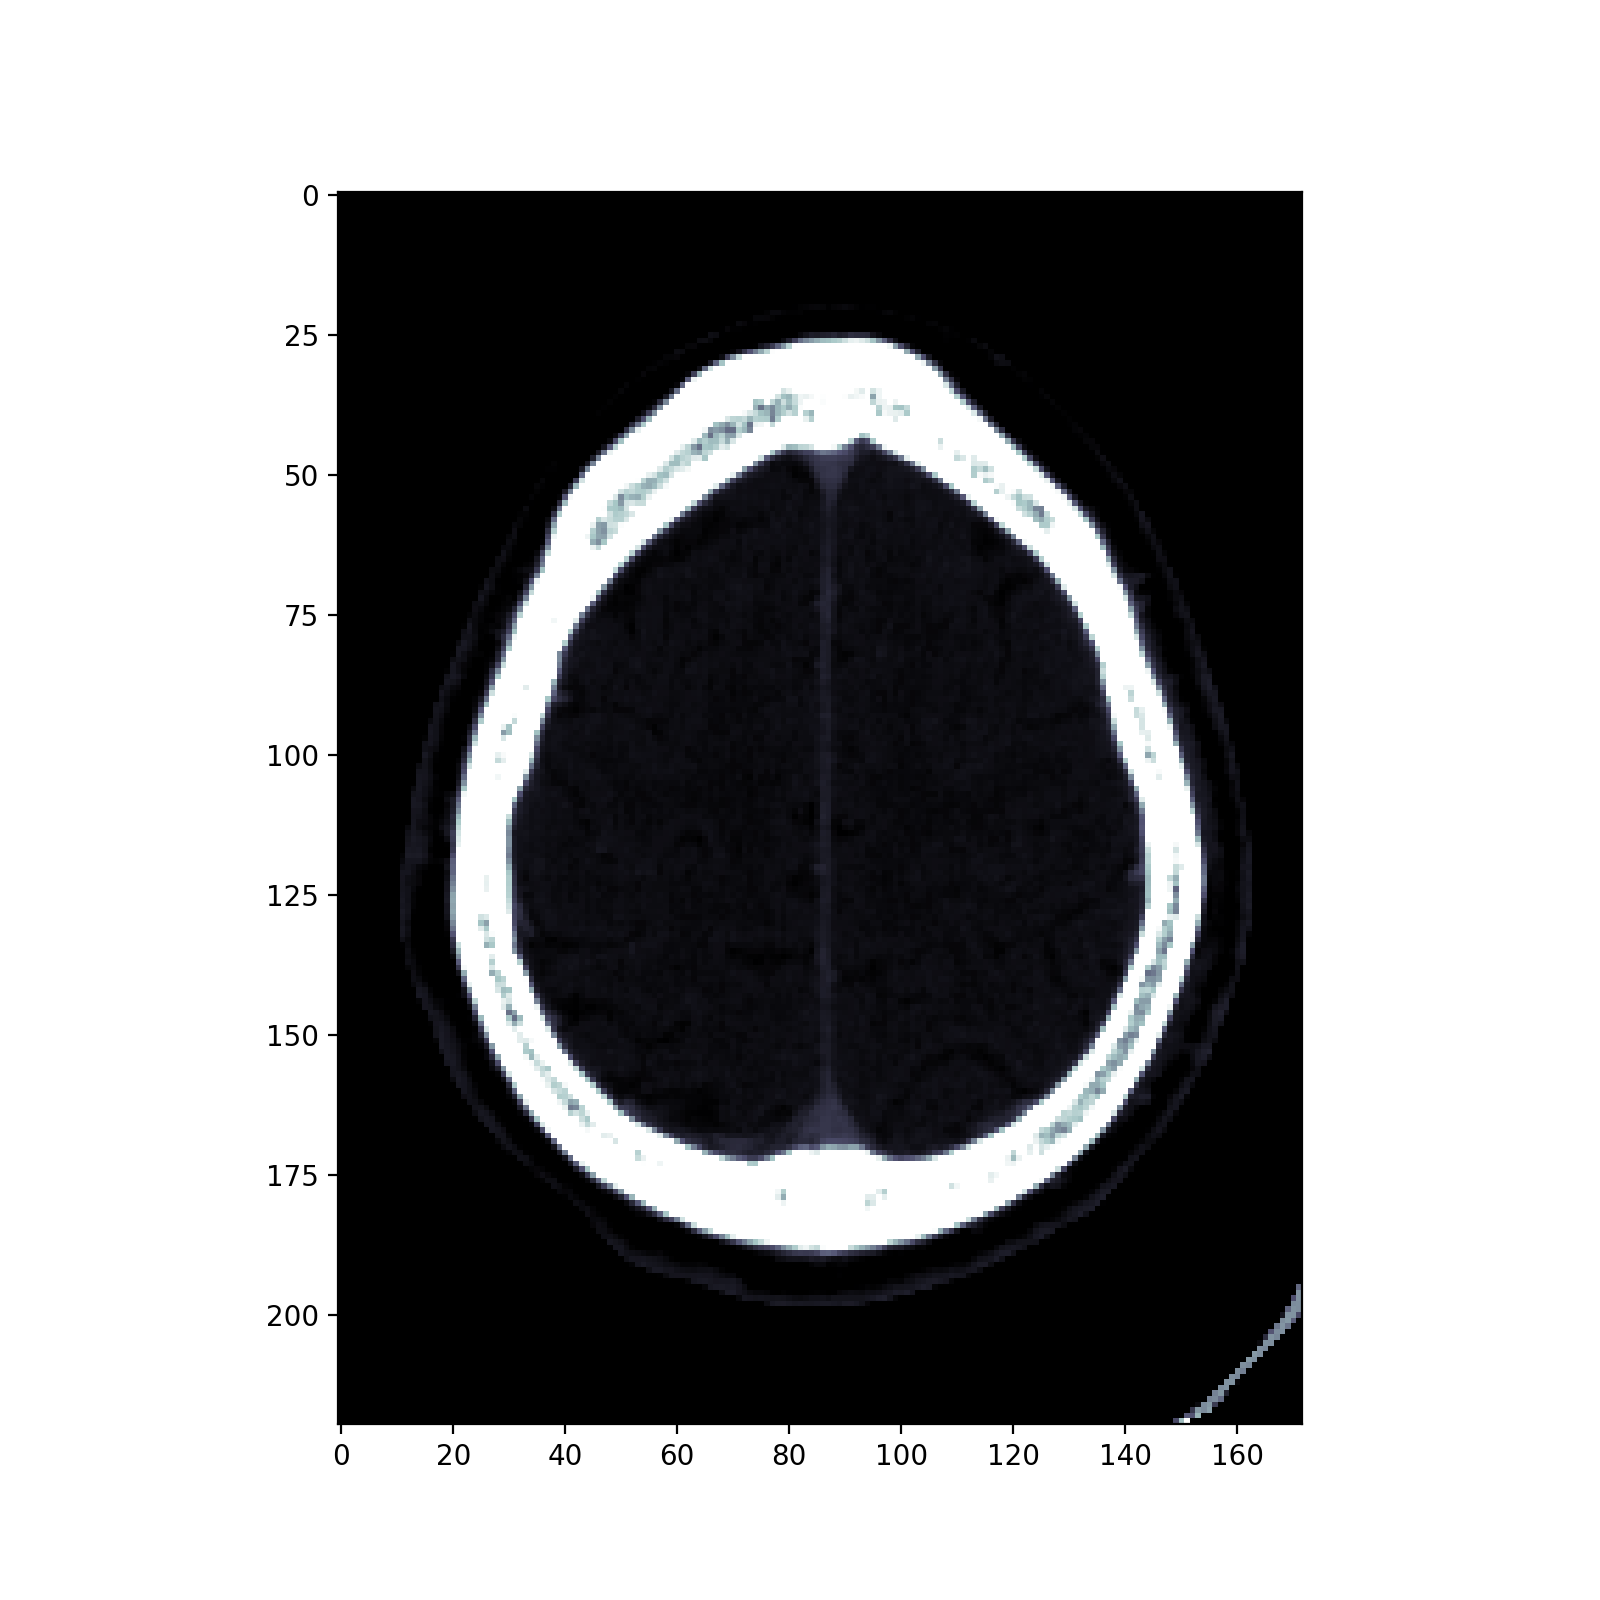

interactive(children=(IntSlider(value=10, description='slice_number', max=155), IntSlider(value=600, descripti…

In [59]:
interactive_3d(registered_series_array)

<IPython.core.display.Javascript object>


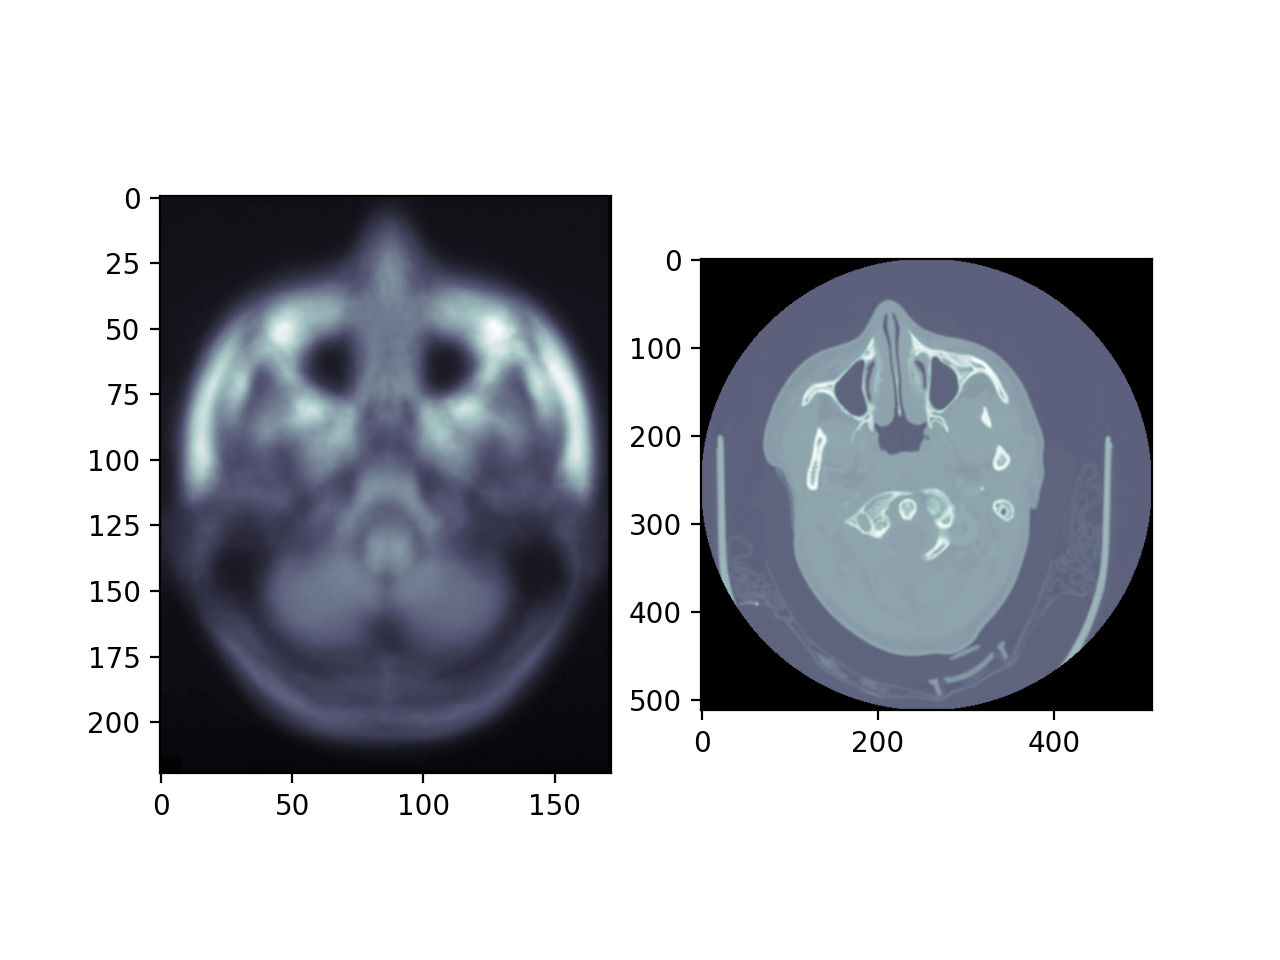

interactive(children=(IntSlider(value=10, description='slice_number', max=238), IntSlider(value=-1, descriptio…

In [18]:
interactive_3d_two_scans(static_series, moving_series)

<IPython.core.display.Javascript object>


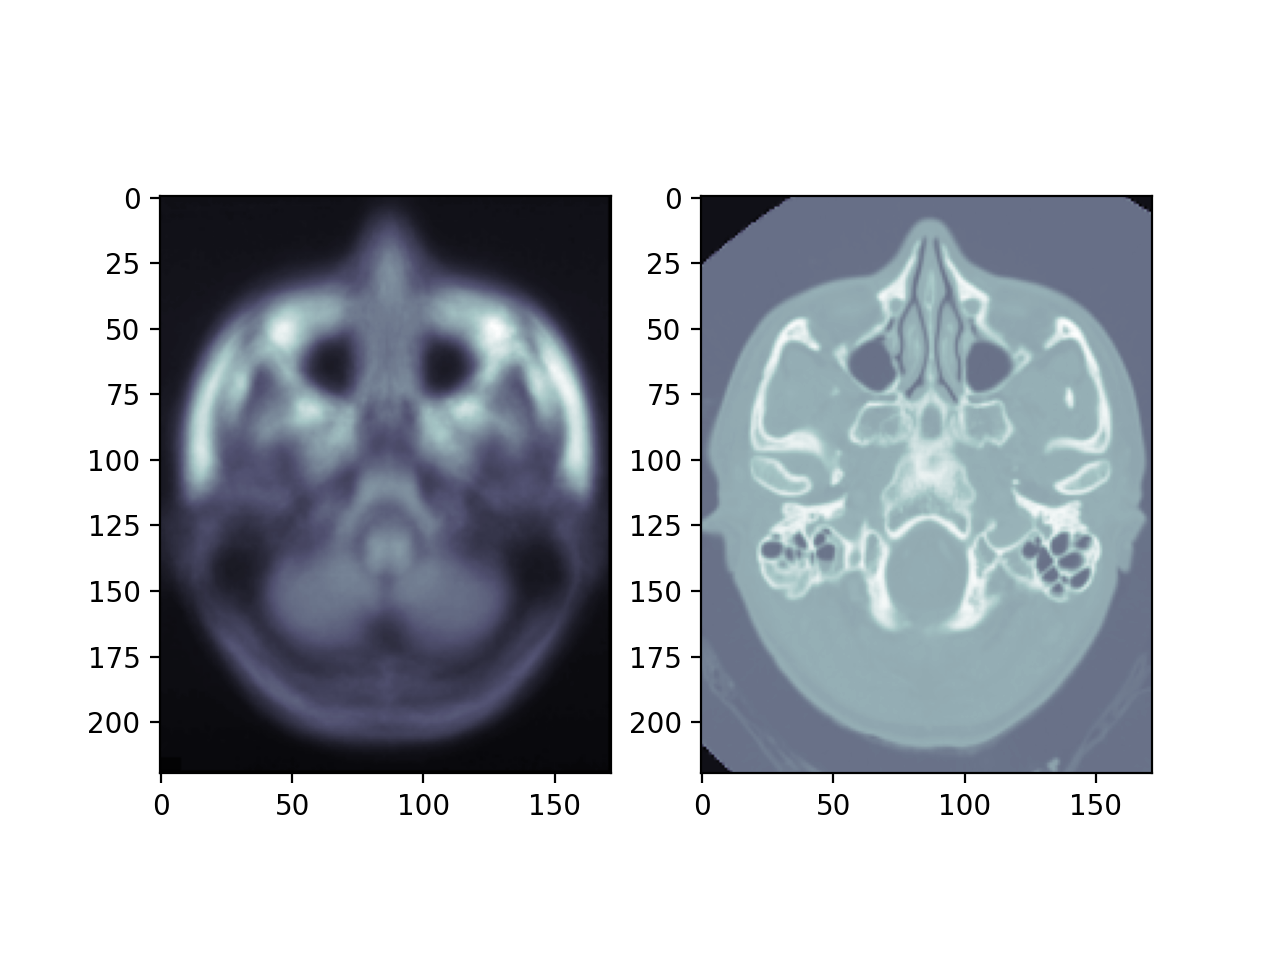

interactive(children=(IntSlider(value=10, description='slice_number', max=155), IntSlider(value=-1, descriptio…

In [60]:
interactive_3d_two_scans(static_series, registered_series_array)

# Using MRI mask on the CT

In [14]:
mask_path = '/path/to/your/file/average305_t1_tal_lin_mask.nii'
mask = nib.load(mask_path).get_data()
mask = np.transpose(mask, [2, 1, 0])
mask = np.flip(mask, 1)
mask.shape

/Users/clara/.virtualenvs/vizdev3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



(156, 220, 172)

<IPython.core.display.Javascript object>


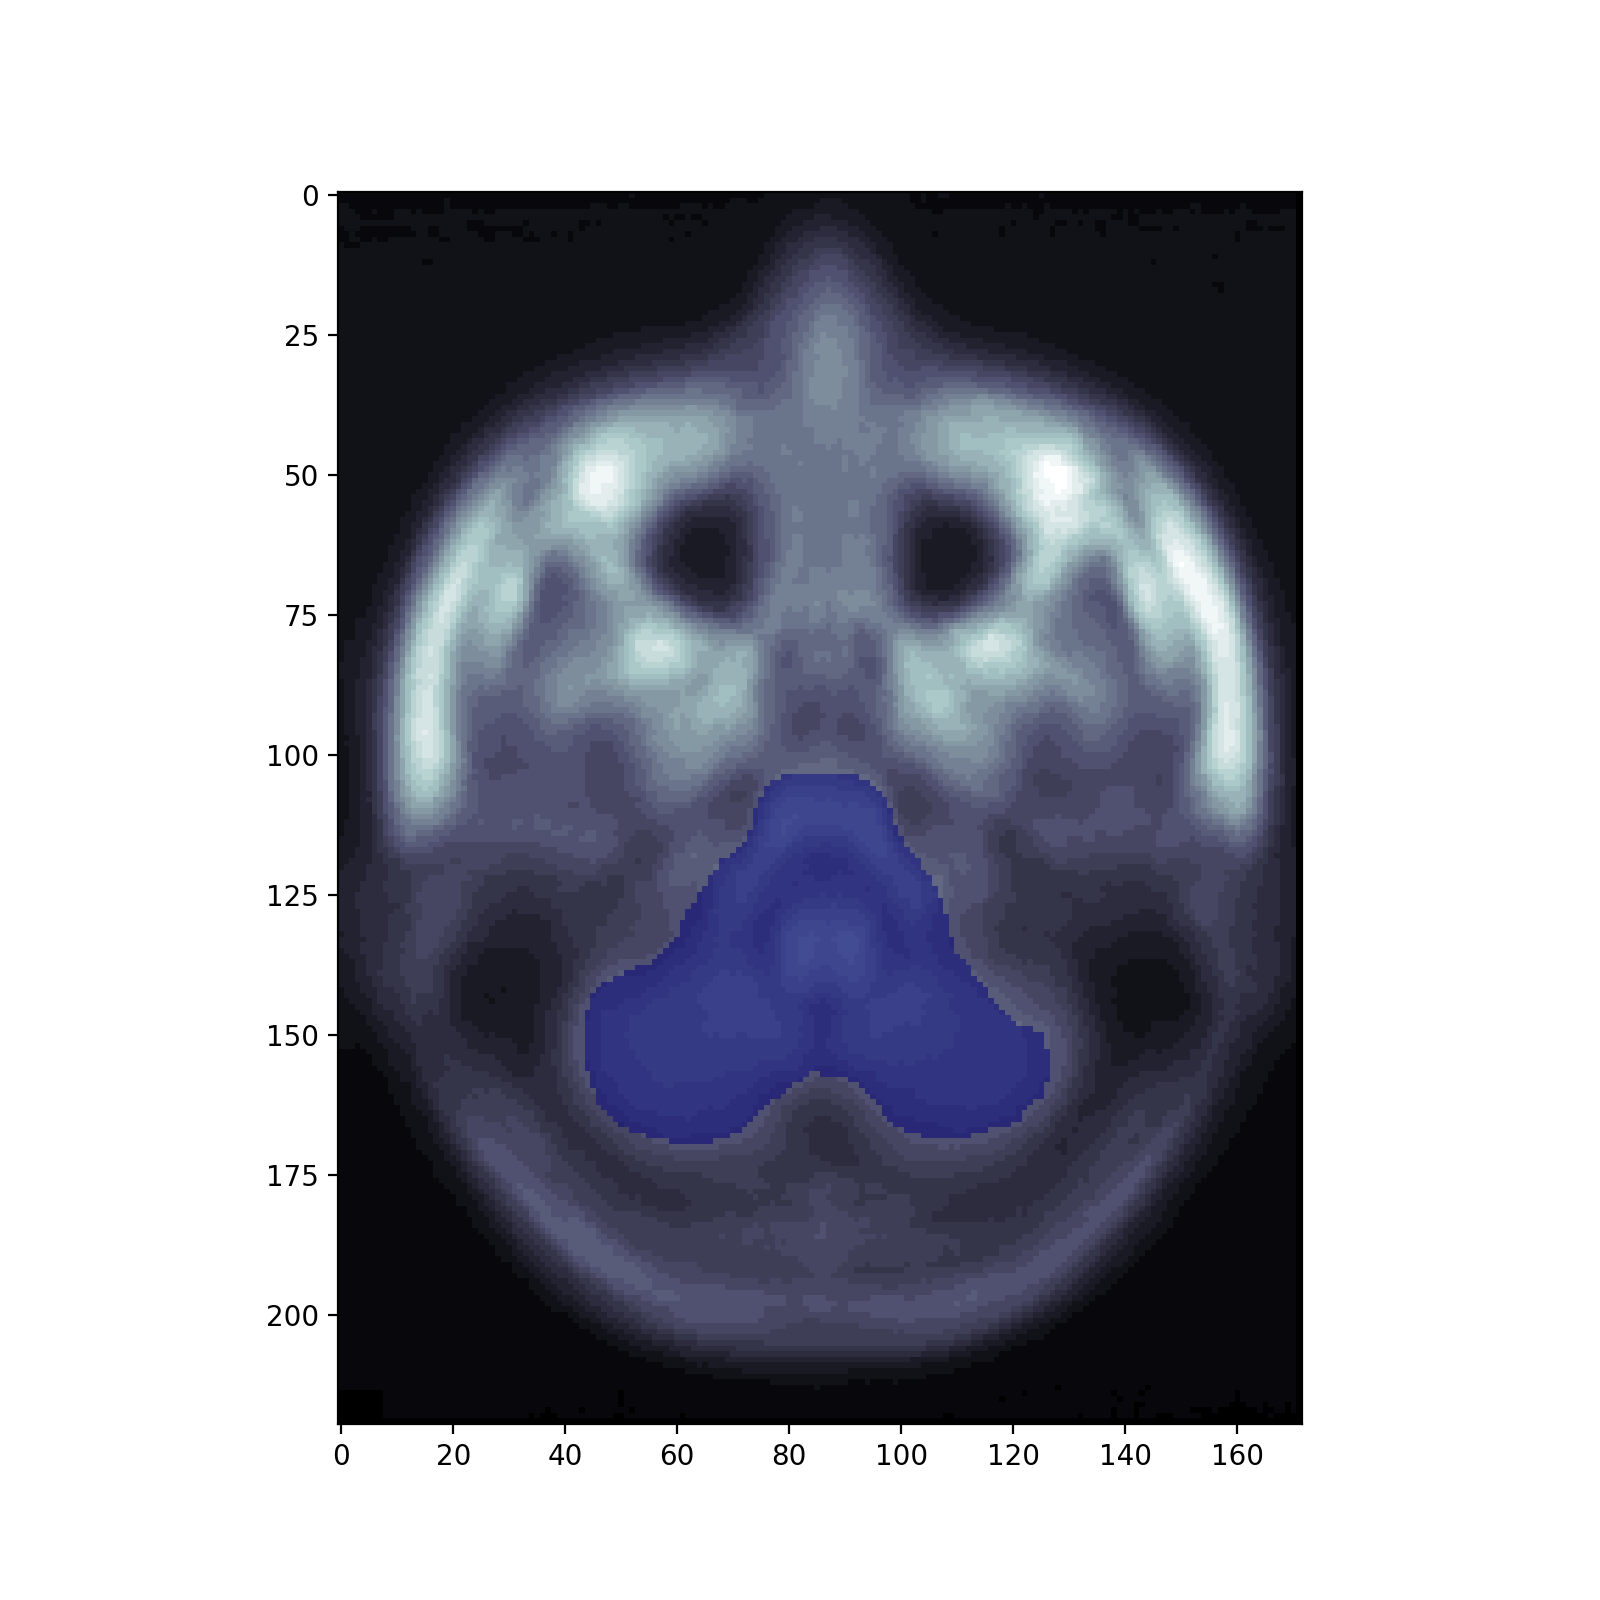

interactive(children=(IntSlider(value=10, description='slice_number', max=155), IntSlider(value=600, descripti…

In [16]:
interactive_3d(static_series, mask=mask)

In [52]:
def apply_inverse_transformation(reference_ants: ants.ANTsImage, moving_ants: ants.ANTsImage, transformation: dict, interpolator: str = INTERPOLATION_TYPE) -> ants.ANTsImage:
    return ants.apply_transforms(fixed=reference_ants, moving=moving_ants,
                                 transformlist=transformation['invtransforms'], interpolator=interpolator, verbose=True)


In [61]:
mask_ants = get_ants_from_numpy(mask)
transformed_mask_ants = apply_inverse_transformation(get_ants_from_numpy(moving_series), mask_ants, 
                                                transformation, interpolator='nearestNeighbor')

['-d', '3', '-i', '0x7fc4bae95d10', '-o', '0x7fc4b974ba40', '-r', '0x7fc4bb3626a0', '-n', 'nearestNeighbor', '-t', '[/var/folders/jw/myx7w5611j1150smt68z8dyr0000gn/T/tmpp9nene3b0GenericAffine.mat,1]', '-t', '/var/folders/jw/myx7w5611j1150smt68z8dyr0000gn/T/tmpp9nene3b1InverseWarp.nii.gz']


In [62]:
transformed_mask = get_numpy_from_ants(transformed_mask_ants)
transformed_mask.shape

(239, 512, 512)

<IPython.core.display.Javascript object>


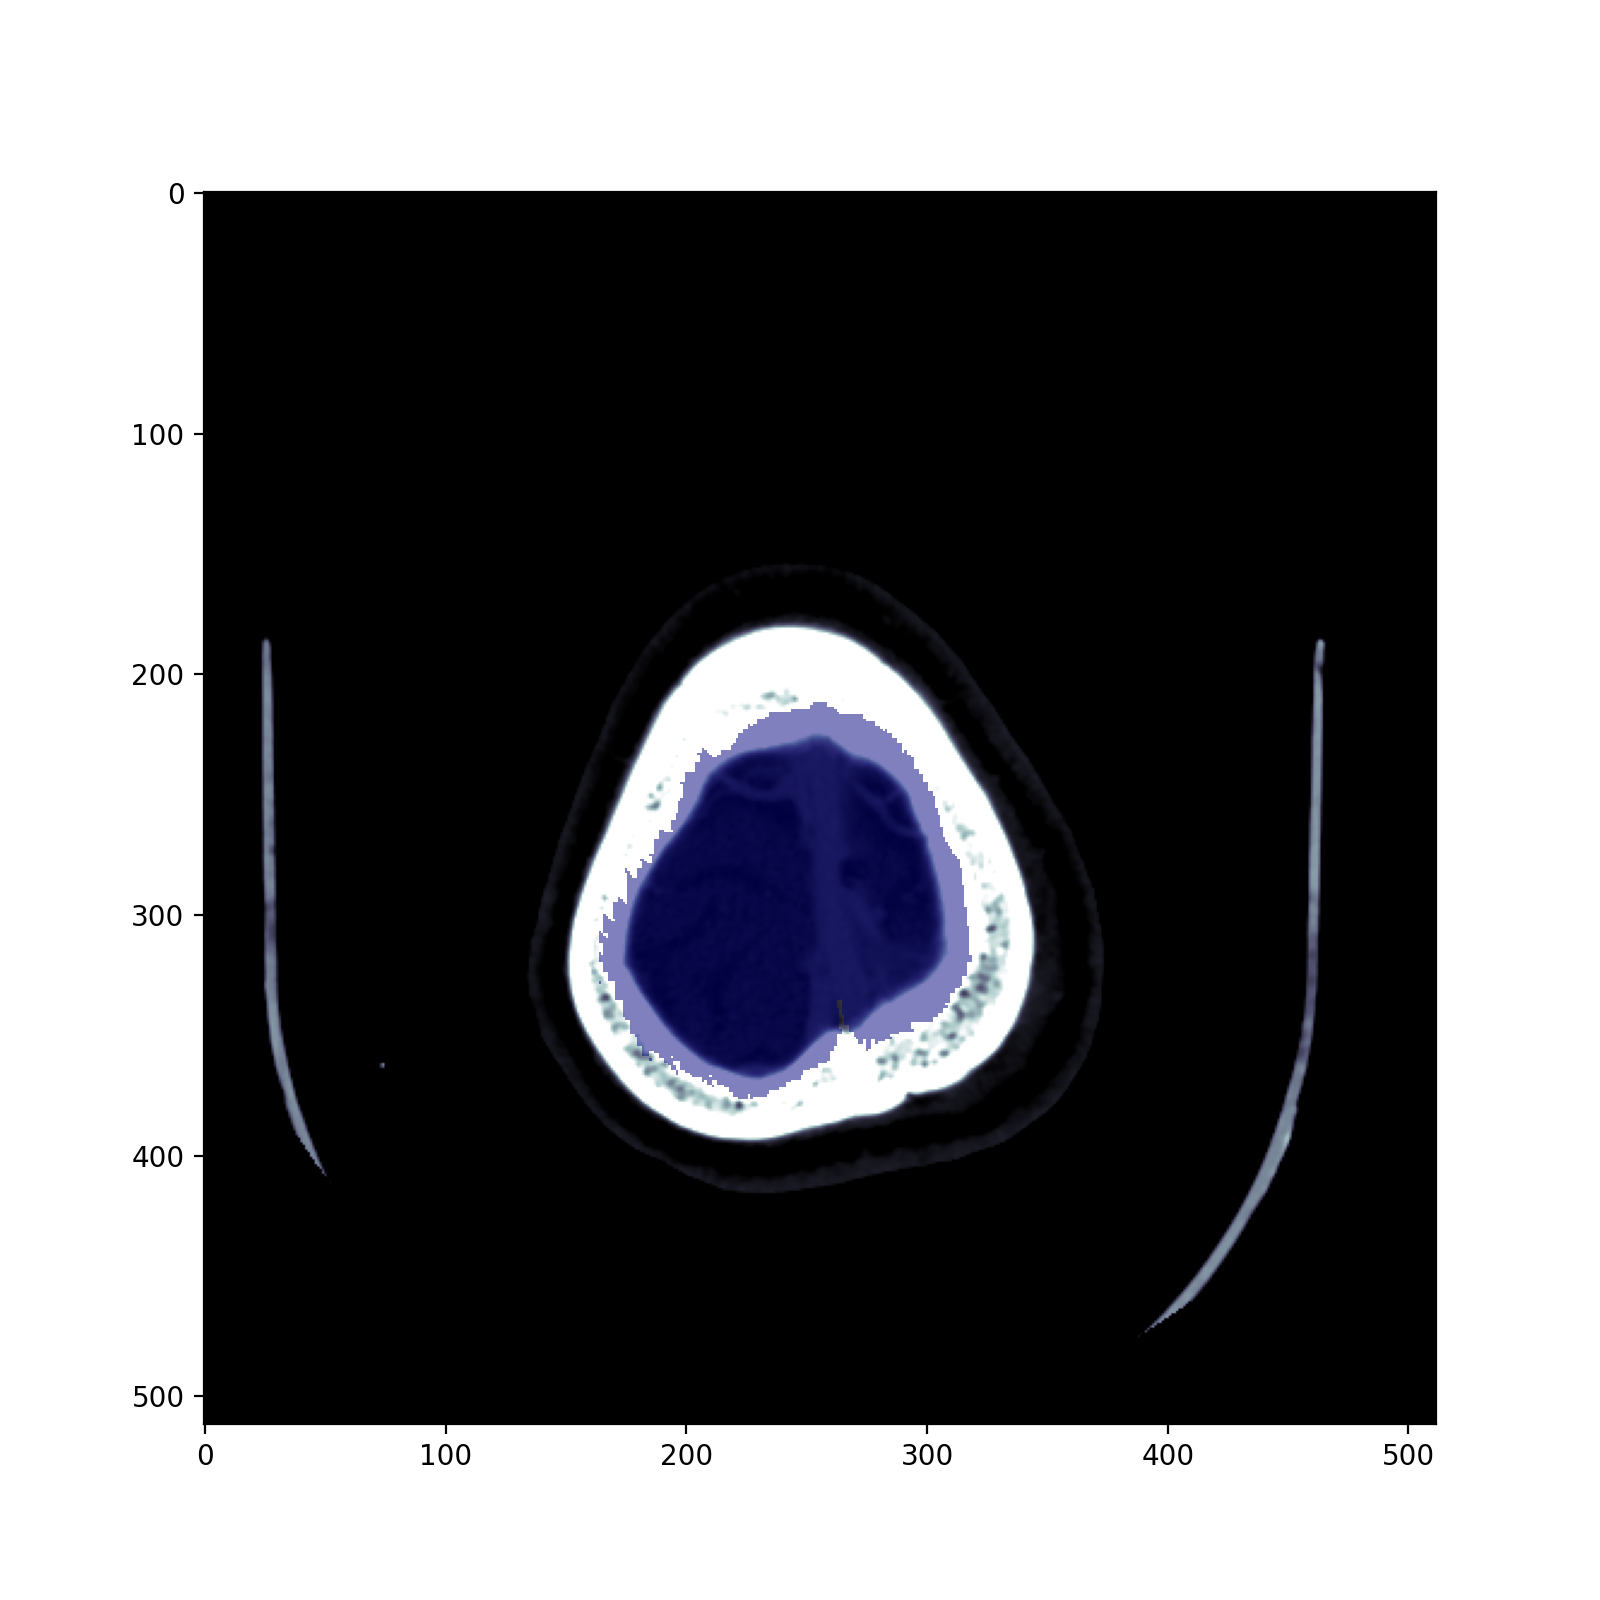

interactive(children=(IntSlider(value=10, description='slice_number', max=238), IntSlider(value=600, descripti…

In [63]:
interactive_3d(moving_series, mask=transformed_mask)

<IPython.core.display.Javascript object>


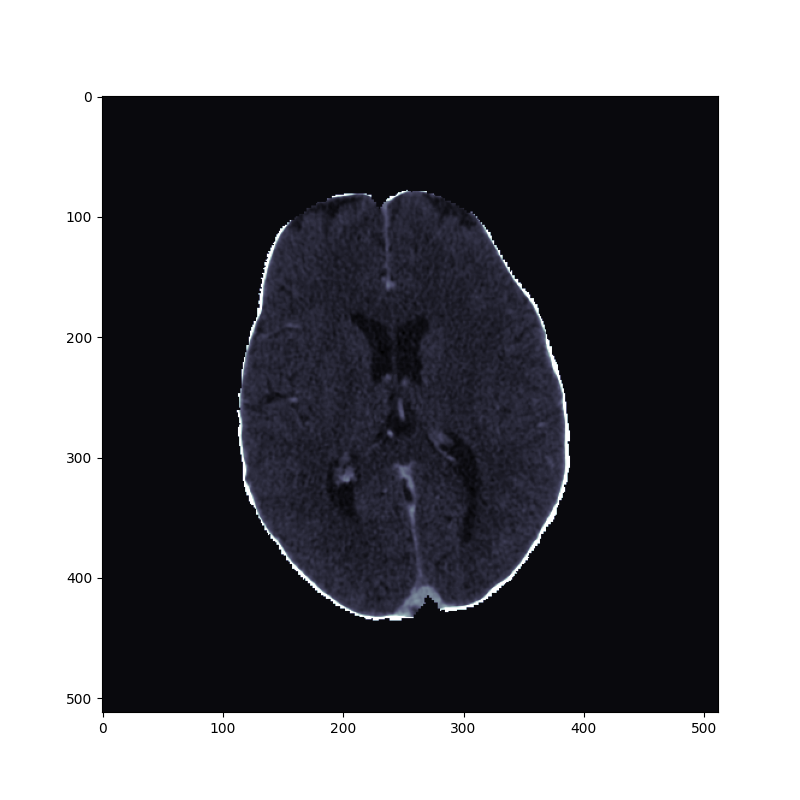

interactive(children=(IntSlider(value=10, description='slice_number', max=238), IntSlider(value=600, descripti…

In [151]:
interactive_3d(moving_series * transformed_mask)